# **Healthcare Fraud Detection (Binary Classification)**


---

## **Problem**
Fraud detection in healthcare claims. This project aims to build a supervised ML system to classify **fraud vs non-fraud** claims, using the NHIS Healthcare Claims and Fraud dataset [Kaggle](https://www.kaggle.com/datasets/bonifacechosen/nhis-healthcare-claims-and-fraud-dataset).

The NHIS Healthcare Claims and Fraud Dataset is a real and simulated dataset designed to explore healthcare claims processing, fraud detection, and billing analysis. This dataset is a combination of both real and simulated data, featuring a mix of legitimate and fraudulent claims annotated for machine learning and analytics purposes.

**Key Questions**
- Which features are most predictive of fraudulent claims?
- How do we handle severe class imbalance while maximizing **recall** (catching fraud) without overly sacrificing precision?
- How do we explain model decisions to stakeholders (auditors, SIU teams)?

**Deliverables**
- Clean, documented pipeline from data → model → evaluation.
- Metrics with emphasis on **Recall**, **Precision**, **F1**, **ROC-AUC**.
- Explainability (feature importance + SHAP).

**Fraud Scenarios**

The dataset includes various fraud types:

- No Fraud: Legitimate claims with valid billing information.
- Fake Treatment: Claims for treatments that were never provided.
- Phantom Billing: Overcharging or claiming for services not rendered.

---


# **0.&nbsp;Connect to G-Drive**

In [61]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [62]:
import os
default_dir = "/content/drive/MyDrive/self learning/Self Project/Fraud Detection/assets"
folder_path = os.path.dirname(default_dir)
os.chdir(folder_path)

In [63]:
!ls

assets	catboost_info


# **1.&nbsp;Setup and Initialization**

<div style="border-radius:10px; padding: 15px; background-color: #ffeacc; font-size:120%; text-align:left">
    
First of all, we will import all the necessary libraries that we will use throughout the project. This generally includes libraries for data manipulation, data visualization, and others based on the specific needs of the project:

In [64]:
!pip install catboost
!pip install category_encoders

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Core
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(rc={'axes.facecolor': '#fcf0dc'}, style='darkgrid')
plt.rcParams['figure.figsize'] = (10, 5)

# Scikit-learn: prep & pipeline
from sklearn.model_selection import train_test_split
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


# Imbalance handling
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Metrics & curves
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    PrecisionRecallDisplay
)

# Machine learning model
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    precision_recall_fscore_support, accuracy_score
)
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [65]:
# Configure Seaborn plot styles: Set background color and use dark grid
sns.set(
    rc={'axes.facecolor': '#fcf0dc'},
    style='darkgrid'
)

## 1.2. Loading the Dataset


<div style="border-radius:10px; padding: 15px; background-color: #ffeacc; font-size:120%; text-align:left">
    
Next, we will load the dataset into a pandas DataFrame which will facilitate easy manipulation and analysis:

In [66]:
# Choose file
file_name = "combined_nhis_dataset_with_fraud_types (1).csv"

# load dataset
df = pd.read_csv(os.path.join("assets", file_name))

## 1.3. Data Description

| **Variable**          | **Description**                                                                          |
| :-------------------- | :--------------------------------------------------------------------------------------- |
| **Patient ID**        | Unique identifier assigned to each patient.                                              |
| **AGE**               | Age of the patient (in years).                                                           |
| **GENDER**            | Gender of the patient (e.g., M/F).                                                       |
| **DATE OF ENCOUNTER** | Date when the patient first visited the healthcare facility.                             |
| **DATE OF DISCHARGE** | Date when the patient was discharged from the healthcare facility.                       |
| **Amount Billed**     | The billed amount (in local currency).                                                   |
| **DIAGNOSIS**         | Diagnosis given to the patient during the encounter.                                     |
| **FRAUD\_TYPE**       | Type of fraud detected in the healthcare claim (e.g., Phantom Billing, Wrong Diagnosis). |


# **2.&nbsp;Initial Data Analysis**

Afterward, we are going to gain a thorough understanding of the dataset before proceeding to the data cleaning and transformation stages.

## 2.1. Dataset Overview

First, we will perform a preliminary analysis to understand the structure and types of data columns:

In [67]:
df.head(10)

,Patient ID,AGE,GENDER,DATE OF ENCOUNTER,DATE OF DISCHARGE,Amount Billed,DIAGNOSIS,FRAUD_TYPE
0,1,25.000000,F,2025-02-11,2025-02-11,16800.0,CYESIS LMP,Phantom Billing
1,2,30.000000,M,2025-02-13,2025-02-13,6300.0,WAX IMPACTION,Wrong Diagnosis
2,3,35.000000,M,2025-02-13,2025-02-13,6160.0,CYESIS LMP,Wrong Diagnosis
3,4,48.000000,M,2025-02-18,2025-02-18,0.0,TONSILITIS OBSTRUCTIVE SLEEP APEANA,Ghost Enrollee
4,5,58.000000,F,2025-02-18,2025-02-18,8400.0,REFRACTIVE ERROR,No Fraud
5,6,65.000000,M,2025-02-20,2025-02-20,11970.0,HTN,Phantom Billing
6,7,25.000000,M,2025-02-22,2025-02-22,0.0,ABDOMINAL PAIN CAUSE,Ghost Enrollee
7,8,23.000000,M,2025-02-13,2025-02-13,0.0,CYESIS HEPATITIS,Wrong Diagnosis
8,9,45.228487,M,2025-02-17,2025-02-17,0.0,EARLY CYESIS TRIMESTER,Wrong Diagnosis
9,10,45.228487,M,2025-02-25,2025-02-25,0.0,APICAL PERIONDONTITIS,Ghost Enrollee


In [68]:
df.tail(10)

,Patient ID,AGE,GENDER,DATE OF ENCOUNTER,DATE OF DISCHARGE,Amount Billed,DIAGNOSIS,FRAUD_TYPE
20378,19991,43.0,F,2022-04-14 00:00:00,2021-09-27 00:00:00,3017.0,DM GERD,No Fraud
20379,19992,14.0,M,2025-01-06 00:00:00,2025-12-18 00:00:00,14348.0,DYSPEPSIALUMBAR SPONDYLOSIS R/O DYSLIPIDEMI,No Fraud
20380,19993,84.0,F,2022-04-21 00:00:00,2020-05-18 00:00:00,19398.0,SECONDARY INFERTILITY PID,Phantom Billing
20381,19994,14.0,M,2020-03-02 00:00:00,2024-04-18 00:00:00,14055.0,POORLY TREATED MALARIA,No Fraud
20382,19995,94.0,M,2022-01-15 00:00:00,2025-07-05 00:00:00,2474.0,RECTAL CA DM,No Fraud
20383,19996,36.0,F,2024-06-27 00:00:00,2020-10-18 00:00:00,18562.0,HHDX HEART FAILURE HTN,Phantom Billing
20384,19997,50.0,M,2020-07-11 00:00:00,2020-11-21 00:00:00,11893.0,HUMERUS FRACTURE,No Fraud
20385,19998,29.0,M,2023-07-06 00:00:00,2021-10-13 00:00:00,5980.0,EARLY CYESIS IN A KNOWN PCOS & DM Pt WITH POOR...,Wrong Diagnosis
20386,19999,43.0,M,2024-03-24 00:00:00,2023-11-06 00:00:00,10696.0,SOLITARY RGT UPPER CERVICAL LYMPH ADENOPHATY C...,Phantom Billing
20387,20000,80.0,M,2024-04-10 00:00:00,2023-03-18 00:00:00,14658.0,ABDOMINAL PAIN CAUSE R/O ADHESIONS,Phantom Billing


In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20388 entries, 0 to 20387
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Patient ID         20388 non-null  int64  
 1   AGE                20388 non-null  float64
 2   GENDER             20388 non-null  object 
 3   DATE OF ENCOUNTER  19847 non-null  object 
 4   DATE OF DISCHARGE  19729 non-null  object 
 5   Amount Billed      20388 non-null  float64
 6   DIAGNOSIS          20350 non-null  object 
 7   FRAUD_TYPE         20388 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 1.2+ MB


### 2.1.1. Overview Inference

The dataset consists of 20,388 entries and 8 columns. Here is a brief overview of each column:

* __`Patient ID`__: An integer column that uniquely identifies each patient.

* __`AGE`__: A float column indicating the age of the patient (in years).

* __`GENDER`__: An object column representing the gender of the patient (e.g., M/F).

* __`DATE OF ENCOUNTER`__: An object column recording the date of the patient’s encounter with the healthcare facility. This column has 19,847 non-null entries, indicating some missing values.

* __`DATE OF DISCHARGE`__: An object column recording the discharge date of the patient. This column has 19,729 non-null entries, also with some missing values.

* __`Amount Billed`__: A float column representing the billed amount (in local currency).

* __`DIAGNOSIS`__: An object column containing the diagnosis assigned to the patient. It has 20,350 non-null entries, meaning a small number of records are missing diagnosis information.

* __`FRAUD_TYPE`__: An object column specifying the type of fraud associated with the claim (e.g., Phantom Billing, Wrong Diagnosis).

From this overview, we can see that there are missing values in the __`DATE OF DISCHARGE`__, __`DATE OF DISCHARGE`__, and  __`DIAGNOSIS`__ columns. These will need to be handled during data preprocessing.

The __`Patient ID`__ column can serve as a unique identifier, while categorical features like __`GENDER`__, __`DIAGNOSIS`__, and __`FRAUD_TYPE`__ may need encoding for modeling. The __`DATE OF ENCOUNTER`__ and __`DATE OF DISCHARGE`__ columns may also be converted to datetime format for further temporal analysis.

The next steps would involve addressing missing values, ensuring correct data types (particularly for date fields), and exploring potential new features to support analysis and modeling objectives.

## 2.2. Summary Statistics

<div style="border-radius:10px; padding: 15px; background-color: #ffeacc; font-size:120%; text-align:left">
    
Now, I am going to generate summary statistics to gain initial insights into the data distribution:

In [70]:
df.describe()

,Patient ID,AGE,Amount Billed
count,20388.000000,20388.000000,20388.000000
mean,9813.883951,47.355827,8337.035987
std,5873.332556,24.269005,6575.295187
min,1.000000,1.000000,0.000000
25%,4709.750000,30.000000,2072.750000
50%,9806.500000,45.228487,7966.000000
75%,14903.250000,65.000000,13949.250000
max,20000.000000,95.000000,110000.000000


In [71]:
# Summary statistics for numerical variables
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Patient ID,20388.0,9813.883951,5873.332556,1.0,4709.75,9806.500000,14903.25,20000.0
AGE,20388.0,47.355827,24.269005,1.0,30.00,45.228487,65.00,95.0
Amount Billed,20388.0,8337.035987,6575.295187,0.0,2072.75,7966.000000,13949.25,110000.0


In [72]:
# Summary statistics for categorical variables
df.describe(include='object').T

,count,unique,top,freq
GENDER,20388,6,F,10610
DATE OF ENCOUNTER,19847,2634,2024-02-29,173
DATE OF DISCHARGE,19729,2639,2024-02-29,174
DIAGNOSIS,20350,1771,REFRACTIVE ERROR,368
FRAUD_TYPE,20388,4,No Fraud,11704


In [73]:
df[df['FRAUD_TYPE'] == "No Fraud"]

,Patient ID,AGE,GENDER,DATE OF ENCOUNTER,DATE OF DISCHARGE,Amount Billed,DIAGNOSIS,FRAUD_TYPE
4,5,58.0,F,2025-02-18,2025-02-18,8400.0,REFRACTIVE ERROR,No Fraud
10,11,92.0,F,2025-02-26,2025-02-26,5320.0,POST TENSION BAND WIRING LFT PATELLAR FRACTURE,No Fraud
13,14,25.0,M,2025-03-03,2025-03-03,8820.0,LUMBASPONDYLISIS,No Fraud
16,17,30.0,M,2025-03-04,2025-03-04,6308.4,HTN,No Fraud
17,18,42.0,M,2025-03-06,2025-03-06,9920.0,LUMBAR SPONDYLOSIS BPH,No Fraud
...,...,...,...,...,...,...,...,...
20378,19991,43.0,F,2022-04-14 00:00:00,2021-09-27 00:00:00,3017.0,DM GERD,No Fraud
20379,19992,14.0,M,2025-01-06 00:00:00,2025-12-18 00:00:00,14348.0,DYSPEPSIALUMBAR SPONDYLOSIS R/O DYSLIPIDEMI,No Fraud
20381,19994,14.0,M,2020-03-02 00:00:00,2024-04-18 00:00:00,14055.0,POORLY TREATED MALARIA,No Fraud
20382,19995,94.0,M,2022-01-15 00:00:00,2025-07-05 00:00:00,2474.0,RECTAL CA DM,No Fraud


### 2.2.1. Summary Inference

| **Variable**          | **Description**                                                                                                                                                                                  |
| --------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| **Patient ID**        | Integer column uniquely identifying each patient (values range from 1 to 20,000). Serves only as an identifier.                                                                                  |
| **AGE**               | Float column indicating patient age in years (min: 1, max: 95, mean ≈ 47.36).                                                                                                                    |
| **GENDER**            | Object column representing patient gender. Contains 6 unique categories, though mostly Male/Female. Data consistency may need verification.                                                      |
| **DATE OF ENCOUNTER** | Object column recording the date of the patient’s encounter with the healthcare facility. 19,847 non-null entries, with some missing values. The most frequent date is Feb 29, 2024 (173 times). |
| **DATE OF DISCHARGE** | Object column recording the patient’s discharge date. 19,729 non-null entries, also with missing values. The most frequent date is Feb 29, 2024 (174 times).                                     |
| **Amount Billed**     | Float column representing the billed amount (min: 0, max: 110,000, mean ≈ 8,337). High variance suggests diverse billing patterns.                                                               |
| **DIAGNOSIS**         | Object column containing medical diagnoses. 20,350 non-null entries with 1,771 unique categories. The most frequent diagnosis is *Refractive Error* (368 times).                                 |
| **FRAUD\_TYPE**       | Object column specifying the type of fraud associated with the claim. Includes 4 categories, with *No Fraud* being the majority (11,704 cases).                                                  |


# **3.&nbsp;Data Cleaning & Transformation**

This step involves a thorough cleaning and transformation process to ensure the dataset is ready for analysis.

It includes:

- Handling missing values in encounter and discharge dates,

- Resolving inconsistencies in categorical fields such as gender and diagnosis,

- Removing duplicate records if present,

- Correcting anomalies in billing amounts (e.g., zero or extreme outliers), and

- Applying any additional transformations required to prepare the data for advanced analysis and modeling.

## 3.1. Handling Missing Values

Initially, we will determine the percentage of missing values present in each column, followed by selecting the most effective strategy to address them:

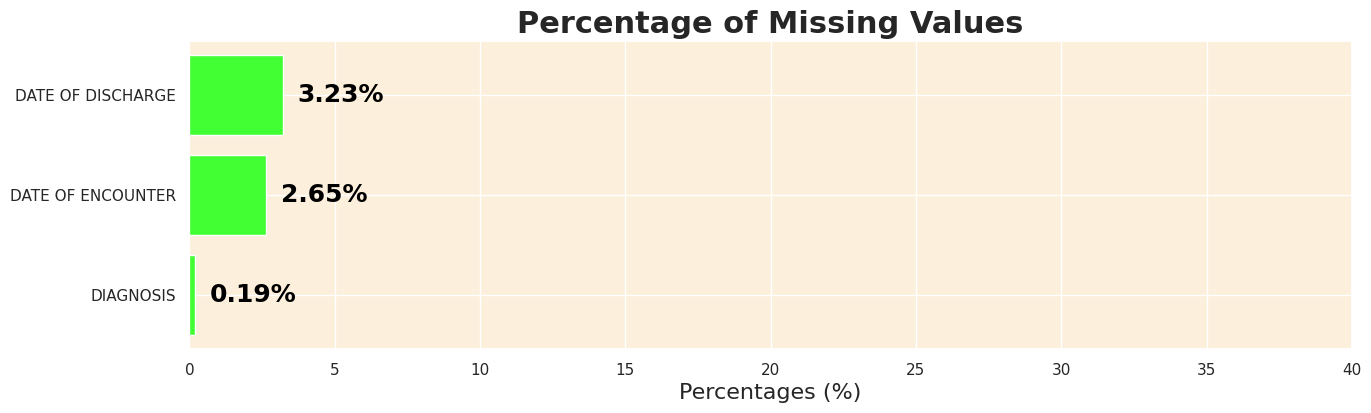

In [74]:
# Calculating the percentage of missing values for each column
missing_data = df.isnull().sum()
missing_percentage = (missing_data[missing_data > 0] / df.shape[0]) * 100

# Prepare values
missing_percentage.sort_values(
    ascending=True,
    inplace=True
)

# Plot the barh chart
fig, ax = plt.subplots(figsize=(15, 4))
ax.barh(
    missing_percentage.index,
    missing_percentage,
    color='#42ff33'
)

# Annotate the values and indexes
for i, (value, name) in enumerate(zip(missing_percentage, missing_percentage.index)):
    ax.text(
        value + 0.5, i, f"{value:.2f}%",
        ha='left',
        va='center',
        fontweight='bold',
        fontsize=18,
        color='black'
    )

# Set x-axis limit
ax.set_xlim([0, 40])

# Add title and xlabel
plt.title("Percentage of Missing Values", fontweight='bold', fontsize=22)
plt.xlabel('Percentages (%)', fontsize=16)
plt.show()

### 3.1.1. Handling Missing Values Strategy:

- **`DATE OF DISCHARGE` (3.23% missing values)**  
  The `DATE OF DISCHARGE` column has the highest proportion of missing values in the dataset. Since discharge dates are critical for understanding patient length of stay and treatment cycles, missing entries may limit the accuracy of temporal or duration-based analyses. Depending on the research goal, possible approaches include imputing missing values using statistical or clinical rules, or removing records if reliable imputation is not feasible.

- **`DATE OF ENCOUNTER` (2.65% missing values)**  
  The `DATE OF ENCOUNTER` column also contains missing data. These dates are essential for constructing timelines of care episodes and for identifying fraud patterns linked to encounter frequency. As with discharge dates, imputing values could introduce noise if not handled carefully. Removing a small proportion of rows with missing encounter dates may be an acceptable trade-off to preserve data quality.

- **`DIAGNOSIS` (0.19% missing values)**  
  The `DIAGNOSIS` column has only a very small fraction of missing entries. Because diagnosis codes are central to both clinical interpretation and fraud detection, imputing these values is not advisable. Given the negligible percentage, it is more robust to drop rows with missing diagnosis values to maintain dataset integrity.


By removing rows with missing values in the **`DATE OF DISCHARGE`, `DATE OF ENCOUNTER`, and `DIAGNOSIS`** columns, where imputation could introduce bias or noise, I aim to construct a cleaner and more reliable dataset. This step is essential to ensure the accuracy of temporal analyses, clinical interpretations, and fraud detection modeling.


In [75]:
# Extracting rows with missing values in 'Date of Discharge' or 'Date of Encounter' or 'Diagnosis' columns
dod_null_mask = df['DATE OF DISCHARGE'].isnull()
doe_null_mask = df['DATE OF ENCOUNTER'].isnull()
diag_null_mask = df['DIAGNOSIS'].isnull()

df[dod_null_mask | doe_null_mask | diag_null_mask].head()

,Patient ID,AGE,GENDER,DATE OF ENCOUNTER,DATE OF DISCHARGE,Amount Billed,DIAGNOSIS,FRAUD_TYPE
40,41,15.000000,M,NaN,2025-07-01,0.0,RVDFRACTURE ACUT APICAL PERIDONTIS,Ghost Enrollee
76,77,45.228487,F,2024-11-20,2024-11-20,6860.0,NaN,No Fraud
143,144,45.228487,F,2024-08-19,NaN,0.0,UNCOMPLICATED MALARIA ACUTE GASTRITIS,Ghost Enrollee
144,145,45.228487,F,2024-07-01,NaN,12000.0,IRREVERSIBLE PULPITIS DENTAL CARIES,No Fraud
145,146,45.228487,M,2024-07-08,NaN,15000.0,REDUCED HEARING LEVEL,No Fraud


In [76]:
# Removing rows with missing values
df = df.dropna(subset=['DATE OF DISCHARGE', 'DATE OF ENCOUNTER', 'DIAGNOSIS'])

In [77]:
# Verifying the removal of missing values
df.isnull().sum()

,0
Patient ID,0
AGE,0
GENDER,0
DATE OF ENCOUNTER,0
DATE OF DISCHARGE,0
Amount Billed,0
DIAGNOSIS,0
FRAUD_TYPE,0


## 3.2. Handling Duplicates

<div style="border-radius:10px; padding: 15px; background-color: #ffeacc; font-size:120%; text-align:left">
    
Next, I am going to recognize duplicate rows in the dataset:

In [78]:
# Finding duplicate rows (keeping all instances)
duplicate_rows = df[df.duplicated(keep=False)]

# Sorting the data by certain columns
# to see the duplicate rows next to each other
duplicate_rows_sorted = duplicate_rows.sort_values(
    by=[
        'Patient ID',
        'AGE',
        'GENDER',
        'DATE OF ENCOUNTER',
        'DATE OF DISCHARGE',
        'Amount Billed'
    ]
)

# Displaying the first 10 records
duplicate_rows_sorted.head(10)

,Patient ID,AGE,GENDER,DATE OF ENCOUNTER,DATE OF DISCHARGE,Amount Billed,DIAGNOSIS,FRAUD_TYPE


## 3.3 Converting Data Types


Next, I am going to convert columns into appropriate data types for analysis:

In [79]:
# 1. Make sure values are strings and strip leading/trailing spaces
df['DATE OF ENCOUNTER'] = df['DATE OF ENCOUNTER'].astype(str).str.strip()
df['DATE OF DISCHARGE'] = df['DATE OF DISCHARGE'].astype(str).str.strip()

# 2. Remove unwanted "00:00:00" (time part) if present
df['DATE OF ENCOUNTER'] = df['DATE OF ENCOUNTER'].str.replace(r"\s*00:00:00", "", regex=True)
df['DATE OF DISCHARGE'] = df['DATE OF DISCHARGE'].str.replace(r"\s*00:00:00", "", regex=True)

# 3. Convert cleaned strings to proper datetime
df['DATE OF ENCOUNTER'] = pd.to_datetime(df['DATE OF ENCOUNTER'], errors='coerce')
df['DATE OF DISCHARGE'] = pd.to_datetime(df['DATE OF DISCHARGE'], errors='coerce')

# 4. (Optional) Check if there are still rows that failed conversion (became NaT)
invalid_encounter = df[df['DATE OF ENCOUNTER'].isna()]
invalid_discharge = df[df['DATE OF DISCHARGE'].isna()]

print("Invalid DATE OF ENCOUNTER rows:", len(invalid_encounter))
print("Invalid DATE OF DISCHARGE rows:", len(invalid_discharge))

Invalid DATE OF ENCOUNTER rows: 0
Invalid DATE OF DISCHARGE rows: 0


In [80]:
df

,Patient ID,AGE,GENDER,DATE OF ENCOUNTER,DATE OF DISCHARGE,Amount Billed,DIAGNOSIS,FRAUD_TYPE
0,1,25.0,F,2025-02-11,2025-02-11,16800.0,CYESIS LMP,Phantom Billing
1,2,30.0,M,2025-02-13,2025-02-13,6300.0,WAX IMPACTION,Wrong Diagnosis
2,3,35.0,M,2025-02-13,2025-02-13,6160.0,CYESIS LMP,Wrong Diagnosis
3,4,48.0,M,2025-02-18,2025-02-18,0.0,TONSILITIS OBSTRUCTIVE SLEEP APEANA,Ghost Enrollee
4,5,58.0,F,2025-02-18,2025-02-18,8400.0,REFRACTIVE ERROR,No Fraud
...,...,...,...,...,...,...,...,...
20383,19996,36.0,F,2024-06-27,2020-10-18,18562.0,HHDX HEART FAILURE HTN,Phantom Billing
20384,19997,50.0,M,2020-07-11,2020-11-21,11893.0,HUMERUS FRACTURE,No Fraud
20385,19998,29.0,M,2023-07-06,2021-10-13,5980.0,EARLY CYESIS IN A KNOWN PCOS & DM Pt WITH POOR...,Wrong Diagnosis
20386,19999,43.0,M,2024-03-24,2023-11-06,10696.0,SOLITARY RGT UPPER CERVICAL LYMPH ADENOPHATY C...,Phantom Billing


In [81]:
# Check NaN in Age Column
print(df['AGE'].isna().sum())

# Show rows with NaN
print(df[df['AGE'].isna()].head())

# Kalau mau lihat distribusi unik
#print(df['AGE'].unique()[:20])  # ambil 20 unik pertama


0
Empty DataFrame
Columns: [Patient ID, AGE, GENDER, DATE OF ENCOUNTER, DATE OF DISCHARGE, Amount Billed, DIAGNOSIS, FRAUD_TYPE]
Index: []


In [82]:
# Is there non-integer value?
has_decimals = (df['AGE'] % 1 != 0).any()
count_decimals = np.sum(df['AGE'] % 1 != 0)

print("Has decimals:", has_decimals, "| Count:", count_decimals)

# Show decimal value
df.loc[df['AGE'] % 1 != 0, 'AGE'].head(10)

Has decimals: True | Count: 3413


,AGE
8,45.228487
9,45.228487
18,45.228487
19,45.228487
20,45.228487
21,45.228487
22,45.228487
23,45.228487
24,45.228487
25,45.228487


In [83]:
# Round AGE to nearest integer and convert to Int64 (nullable int)
df['AGE'] = df['AGE'].round().astype('Int64')

# Sanity check
print(df[['AGE']].head(10))
print("Unique dtype:", df['AGE'].dtype)

   AGE
0   25
1   30
2   35
3   48
4   58
5   65
6   25
7   23
8   45
9   45
Unique dtype: Int64


## 3.4 Feature Engineering
Next, I am going to derive new features from columns to enrich the dataset:


In [84]:
print(df['GENDER'].unique())

['F' 'M' 'f' 'm' 'MF']


In [85]:
# Normalize case → only M/F and drop MF (considered to be error input)
df['GENDER'] = df['GENDER'].str.upper()
df = df[df['GENDER'].isin(['M', 'F'])]

In [86]:
# Length of stay (days)
df['LENGTH_OF_STAY'] = (df['DATE OF DISCHARGE'] - df['DATE OF ENCOUNTER']).dt.days

# Month and Day of Encounter
df['ENCOUNTER_MONTH'] = df['DATE OF ENCOUNTER'].dt.month
df['ENCOUNTER_DAY'] = df['DATE OF ENCOUNTER'].dt.day_name()

In [87]:
# Length of Stay (days)
df['LENGTH_OF_STAY'] = (df['DATE OF DISCHARGE'] - df['DATE OF ENCOUNTER']).dt.days

# Month and Day of Encounter
df['ENCOUNTER_MONTH'] = df['DATE OF ENCOUNTER'].dt.month
df['ENCOUNTER_DAY'] = df['DATE OF ENCOUNTER'].dt.day_name()


In [88]:
df.head(10)

,Patient ID,AGE,GENDER,DATE OF ENCOUNTER,DATE OF DISCHARGE,Amount Billed,DIAGNOSIS,FRAUD_TYPE,LENGTH_OF_STAY,ENCOUNTER_MONTH,ENCOUNTER_DAY
0,1,25,F,2025-02-11,2025-02-11,16800.0,CYESIS LMP,Phantom Billing,0,2,Tuesday
1,2,30,M,2025-02-13,2025-02-13,6300.0,WAX IMPACTION,Wrong Diagnosis,0,2,Thursday
2,3,35,M,2025-02-13,2025-02-13,6160.0,CYESIS LMP,Wrong Diagnosis,0,2,Thursday
3,4,48,M,2025-02-18,2025-02-18,0.0,TONSILITIS OBSTRUCTIVE SLEEP APEANA,Ghost Enrollee,0,2,Tuesday
4,5,58,F,2025-02-18,2025-02-18,8400.0,REFRACTIVE ERROR,No Fraud,0,2,Tuesday
5,6,65,M,2025-02-20,2025-02-20,11970.0,HTN,Phantom Billing,0,2,Thursday
6,7,25,M,2025-02-22,2025-02-22,0.0,ABDOMINAL PAIN CAUSE,Ghost Enrollee,0,2,Saturday
7,8,23,M,2025-02-13,2025-02-13,0.0,CYESIS HEPATITIS,Wrong Diagnosis,0,2,Thursday
8,9,45,M,2025-02-17,2025-02-17,0.0,EARLY CYESIS TRIMESTER,Wrong Diagnosis,0,2,Monday
9,10,45,M,2025-02-25,2025-02-25,0.0,APICAL PERIONDONTITIS,Ghost Enrollee,0,2,Tuesday


In [89]:
df.tail(10)

,Patient ID,AGE,GENDER,DATE OF ENCOUNTER,DATE OF DISCHARGE,Amount Billed,DIAGNOSIS,FRAUD_TYPE,LENGTH_OF_STAY,ENCOUNTER_MONTH,ENCOUNTER_DAY
20378,19991,43,F,2022-04-14,2021-09-27,3017.0,DM GERD,No Fraud,-199,4,Thursday
20379,19992,14,M,2025-01-06,2025-12-18,14348.0,DYSPEPSIALUMBAR SPONDYLOSIS R/O DYSLIPIDEMI,No Fraud,346,1,Monday
20380,19993,84,F,2022-04-21,2020-05-18,19398.0,SECONDARY INFERTILITY PID,Phantom Billing,-703,4,Thursday
20381,19994,14,M,2020-03-02,2024-04-18,14055.0,POORLY TREATED MALARIA,No Fraud,1508,3,Monday
20382,19995,94,M,2022-01-15,2025-07-05,2474.0,RECTAL CA DM,No Fraud,1267,1,Saturday
20383,19996,36,F,2024-06-27,2020-10-18,18562.0,HHDX HEART FAILURE HTN,Phantom Billing,-1348,6,Thursday
20384,19997,50,M,2020-07-11,2020-11-21,11893.0,HUMERUS FRACTURE,No Fraud,133,7,Saturday
20385,19998,29,M,2023-07-06,2021-10-13,5980.0,EARLY CYESIS IN A KNOWN PCOS & DM Pt WITH POOR...,Wrong Diagnosis,-631,7,Thursday
20386,19999,43,M,2024-03-24,2023-11-06,10696.0,SOLITARY RGT UPPER CERVICAL LYMPH ADENOPHATY C...,Phantom Billing,-139,3,Sunday
20387,20000,80,M,2024-04-10,2023-03-18,14658.0,ABDOMINAL PAIN CAUSE R/O ADHESIONS,Phantom Billing,-389,4,Wednesday


In [90]:
df.describe()

,Patient ID,AGE,DATE OF ENCOUNTER,DATE OF DISCHARGE,Amount Billed,LENGTH_OF_STAY,ENCOUNTER_MONTH
count,19647.000000,19647.0,19647,19647,19647.000000,19647.000000,19647.000000
mean,10123.965135,47.39889,2023-04-01 23:30:49.748052992,2023-04-03 13:29:00.907008768,8611.077890,1.582074,6.533109
min,1.000000,1.0,2002-02-04 00:00:00,2020-01-01 00:00:00,0.000000,-2167.000000,1.000000
25%,5256.500000,30.0,2021-11-02 00:00:00,2021-10-11 00:00:00,2605.000000,-470.000000,3.000000
50%,10170.000000,45.0,2023-07-11 00:00:00,2023-07-22 00:00:00,8371.000000,0.000000,7.000000
75%,15084.500000,66.0,2024-09-01 00:00:00,2024-09-09 00:00:00,14168.000000,477.000000,10.000000
max,20000.000000,95.0,2025-12-28 00:00:00,2025-12-28 00:00:00,110000.000000,7729.000000,12.000000
std,5746.876627,24.690835,NaN,NaN,6464.157003,811.516747,3.481399


In [91]:
df.isnull().sum()

,0
Patient ID,0
AGE,0
GENDER,0
DATE OF ENCOUNTER,0
DATE OF DISCHARGE,0
Amount Billed,0
DIAGNOSIS,0
FRAUD_TYPE,0
LENGTH_OF_STAY,0
ENCOUNTER_MONTH,0


## 3.5 Outlier Detection
Next, I am going to detect and handle outliers in numerical features:


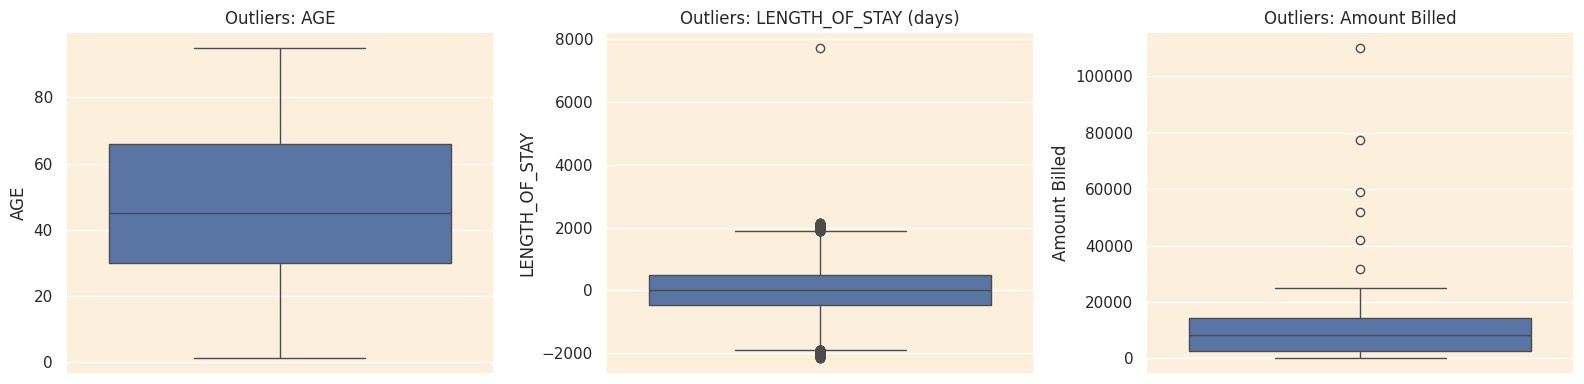

In [92]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Boxplot of AGE to show unrealistic values (too young/too old)
sns.boxplot(y=df['AGE'], ax=axes[0])
axes[0].set_title('Outliers: AGE')

# Boxplot of LENGTH_OF_STAY to reveal negative or extremely long hospital stays
sns.boxplot(y=df['LENGTH_OF_STAY'], ax=axes[1])
axes[1].set_title('Outliers: LENGTH_OF_STAY (days)')

# Boxplot of Amount Billed to highlight unusually high or low charges
sns.boxplot(y=df['Amount Billed'], ax=axes[2])
axes[2].set_title('Outliers: Amount Billed')

plt.tight_layout()
plt.show()

Outlier analysis was conducted across numerical features using boxplots to visually inspect anomalous values. For __`Age`__, values below 0 and above 120 were considered unrealistic and capped within this range. For __`Length of Stay`__, negative values and extremely high values (beyond clinical plausibility) were treated as invalid and removed from the dataset. For __`Amount Billed`__, the Interquartile Range (IQR) method was applied to mitigate the impact of abnormally high or low charges, ensuring the distribution better reflects realistic billing practices. Date-related features were handled separately, where implausible encounter–discharge sequences (e.g., discharge date preceding encounter date) were dropped. These tailored treatments were applied to ensure data integrity without unnecessarily discarding valid records.

In [93]:
# Remove invalid datetime rows where dischare < encounter
mask_invalid_date = (
    df['DATE OF DISCHARGE'] < df['DATE OF ENCOUNTER']
)
df = df[~mask_invalid_date].copy()

# Recalculate LENGTH_OF_STAY after removing invalid dates
df['LENGTH_OF_STAY'] = (df['DATE OF DISCHARGE'] - df['DATE OF ENCOUNTER']).dt.days

# Cap AGE to a realistic human lifespan range (0-120 years)
df['AGE'] = df['AGE'].clip(lower=0, upper=120)

# Restrict LENGTH_OF_STAY: replace negatives with NaN and cap extreme values at 365 days
df.loc[df['LENGTH_OF_STAY'] < 0, 'LENGTH_OF_STAY'] = np.nan
df.loc[df['LENGTH_OF_STAY'] > 365, 'LENGTH_OF_STAY'] = 365

# Winsorize amount Billed using IQR method to reduce influence of extreme charges
Q1 = df['Amount Billed'].quantile(0.25)
Q3 = df['Amount Billed'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
df['Amount Billed'] = df['Amount Billed'].clip(lower=lower, upper=upper)

In [94]:
df.head(10)

,Patient ID,AGE,GENDER,DATE OF ENCOUNTER,DATE OF DISCHARGE,Amount Billed,DIAGNOSIS,FRAUD_TYPE,LENGTH_OF_STAY,ENCOUNTER_MONTH,ENCOUNTER_DAY
0,1,25,F,2025-02-11,2025-02-11,16800.0,CYESIS LMP,Phantom Billing,0.0,2,Tuesday
1,2,30,M,2025-02-13,2025-02-13,6300.0,WAX IMPACTION,Wrong Diagnosis,0.0,2,Thursday
2,3,35,M,2025-02-13,2025-02-13,6160.0,CYESIS LMP,Wrong Diagnosis,0.0,2,Thursday
3,4,48,M,2025-02-18,2025-02-18,0.0,TONSILITIS OBSTRUCTIVE SLEEP APEANA,Ghost Enrollee,0.0,2,Tuesday
4,5,58,F,2025-02-18,2025-02-18,8400.0,REFRACTIVE ERROR,No Fraud,0.0,2,Tuesday
5,6,65,M,2025-02-20,2025-02-20,11970.0,HTN,Phantom Billing,0.0,2,Thursday
6,7,25,M,2025-02-22,2025-02-22,0.0,ABDOMINAL PAIN CAUSE,Ghost Enrollee,0.0,2,Saturday
7,8,23,M,2025-02-13,2025-02-13,0.0,CYESIS HEPATITIS,Wrong Diagnosis,0.0,2,Thursday
8,9,45,M,2025-02-17,2025-02-17,0.0,EARLY CYESIS TRIMESTER,Wrong Diagnosis,0.0,2,Monday
9,10,45,M,2025-02-25,2025-02-25,0.0,APICAL PERIONDONTITIS,Ghost Enrollee,0.0,2,Tuesday


In [95]:
df.tail(10)

,Patient ID,AGE,GENDER,DATE OF ENCOUNTER,DATE OF DISCHARGE,Amount Billed,DIAGNOSIS,FRAUD_TYPE,LENGTH_OF_STAY,ENCOUNTER_MONTH,ENCOUNTER_DAY
20366,19979,63,M,2021-05-27,2023-01-07,18529.0,PALPITATION,No Fraud,365.0,5,Thursday
20367,19980,12,M,2024-10-20,2025-05-05,3001.0,PRETERM CONTRACTION,No Fraud,197.0,10,Sunday
20368,19981,80,F,2020-06-23,2025-03-25,2437.0,SYSTEMIC UTERINE FIBROID,No Fraud,365.0,6,Tuesday
20371,19984,1,M,2023-08-02,2023-08-16,4936.0,UTI AND PROSTATIS,No Fraud,14.0,8,Wednesday
20374,19987,83,M,2021-04-02,2023-03-04,13762.0,PREGESTATIONAL DM IN A PREVIOUS SCAR PREVIOUS C/S,No Fraud,365.0,4,Friday
20377,19990,68,M,2020-07-28,2024-05-16,19755.0,POST TENSION BAND WIRING LEFT PATELLAR / HTN,No Fraud,365.0,7,Tuesday
20379,19992,14,M,2025-01-06,2025-12-18,14348.0,DYSPEPSIALUMBAR SPONDYLOSIS R/O DYSLIPIDEMI,No Fraud,346.0,1,Monday
20381,19994,14,M,2020-03-02,2024-04-18,14055.0,POORLY TREATED MALARIA,No Fraud,365.0,3,Monday
20382,19995,94,M,2022-01-15,2025-07-05,2474.0,RECTAL CA DM,No Fraud,365.0,1,Saturday
20384,19997,50,M,2020-07-11,2020-11-21,11893.0,HUMERUS FRACTURE,No Fraud,133.0,7,Saturday


## 3.6 Checking Class Distribution
Next, I am going to examine the balance of fraud classes in the dataset:


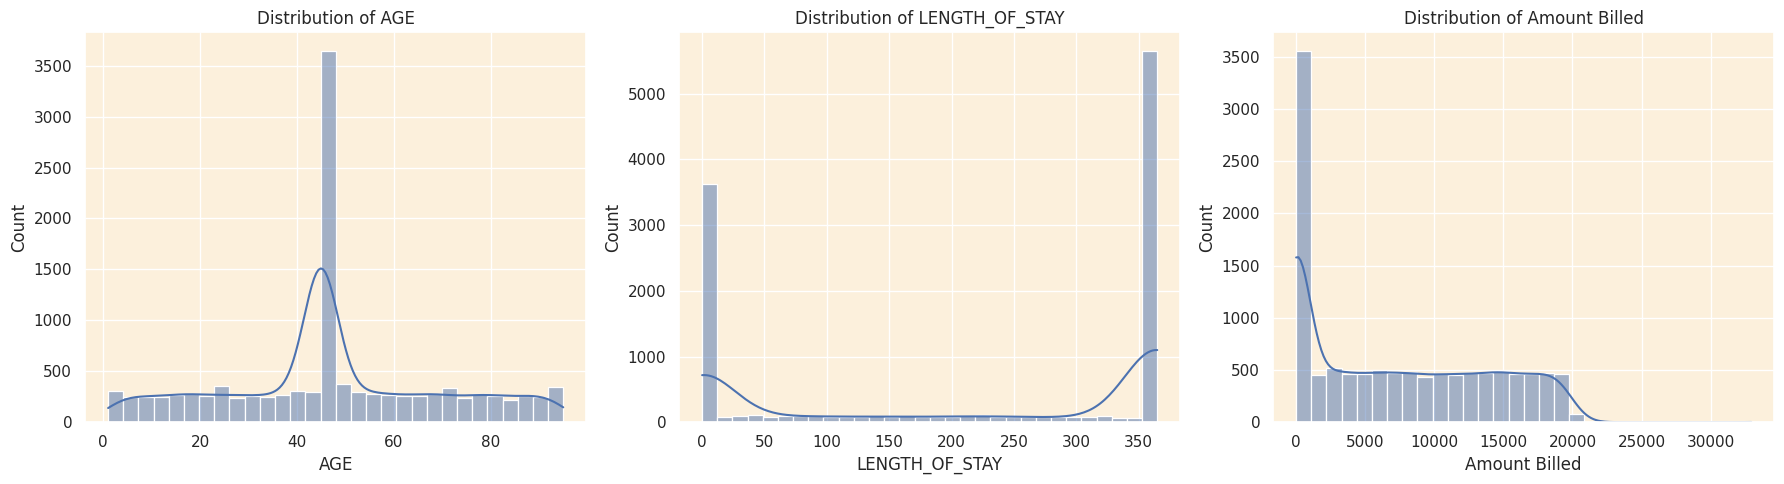

In [96]:
# Numerical feature to check distribution
num_features = ['AGE', 'LENGTH_OF_STAY', 'Amount Billed']

# Plot histogram + KDE for numerical features
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, col in enumerate(num_features):
    # Histogram with KDE to observe distribution shape
    sns.histplot(df[col], kde=True, ax=axes[i], bins=30)
    axes[i].set_title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

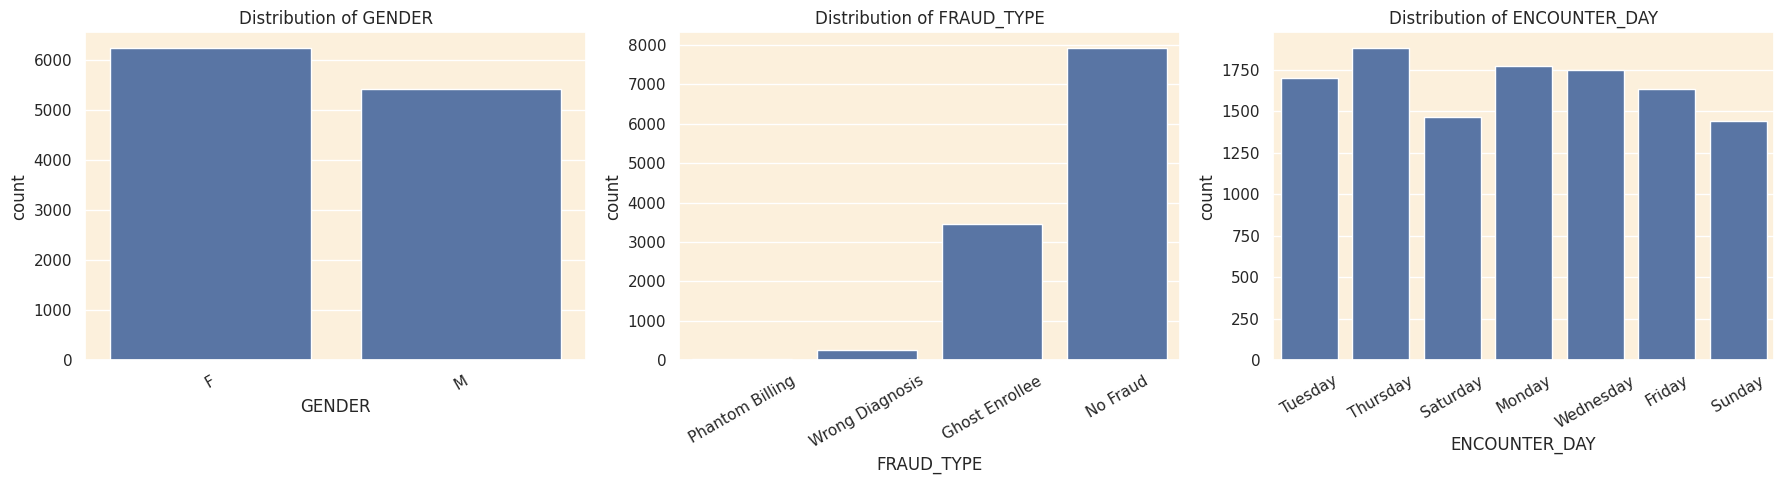

In [97]:
# Categorical features to check frequency
cat_features = ['GENDER', 'FRAUD_TYPE', 'ENCOUNTER_DAY']

# Plot countplots for categorical features
fig, axes = plt.subplots(1,3, figsize = (18, 5))
for i, col in enumerate(cat_features):
    # Countplot to show frequency distribution
    sns.countplot(x=df[col], ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].tick_params(axis = 'x', rotation = 30)
plt.tight_layout()
plt.show()

##### Distribution Analysis

The distribution analysis was conducted to understand the underlying patterns of both numerical and categorical features. For numerical variables, histograms with kernel density estimations (KDE) were plotted. The results indicate that Age is concentrated around middle adulthood with some uniform spread, while Length of Stay shows a highly skewed pattern due to short stays dominating the data. Amount Billed also exhibits a right-skewed distribution, reflecting the presence of unusually high medical charges. For categorical variables, bar plots were used to assess frequency. The dataset demonstrates nearly balanced gender representation, though with some inconsistent labeling (e.g., lowercase entries). Fraud Type is highly imbalanced, with the majority of records belonging to the “No Fraud” category, followed by “Ghost Enrollee,” and very few instances of “Wrong Diagnosis” and “Phantom Billing.” Encounter Day is distributed relatively evenly across the week, although Saturday and Sunday present slightly fewer cases.

# **4.&nbsp;Bivariate Analysis**

In the bivariate analysis, the relationship between each predictor and the target variable (fraud vs. non-fraud) was examined. For numerical features such as Age, Length of Stay, and Amount Billed, boxplots were used to highlight distribution differences between fraudulent and non-fraudulent claims. For categorical features such as Gender and Diagnosis, countplots were employed to observe frequency distributions across fraud classes. This step allows us to identify which features demonstrate meaningful separation between fraud and non-fraud, thereby guiding feature selection and model design.

<Figure size 600x400 with 0 Axes>

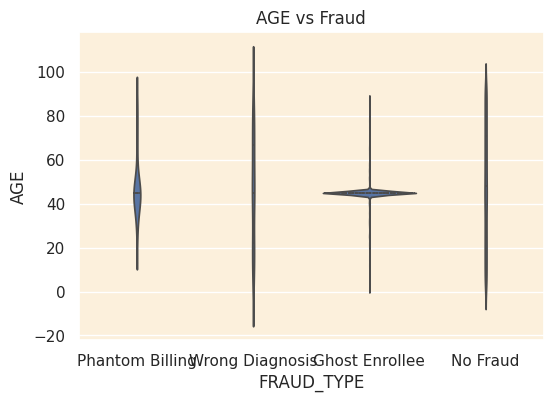

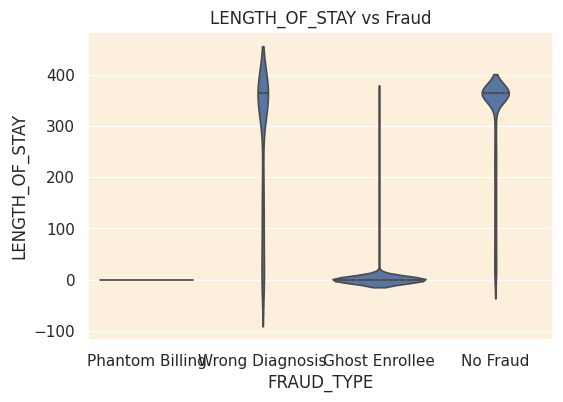

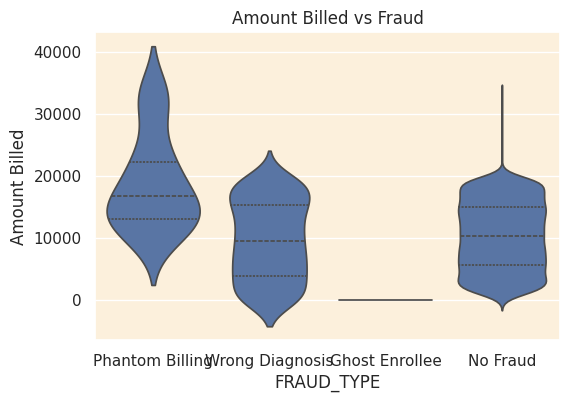

In [98]:
# Compare AGE distribution between Fraud and Non-Fraud using boxplots
plt.figure(figsize = (6,4))
for col in num_features:
    plt.figure(figsize = (6,4))
    sns.violinplot(x='FRAUD_TYPE', y = col, data = df, inner = 'quartile')
    plt.title(f'{col} vs Fraud')
    plt.show()

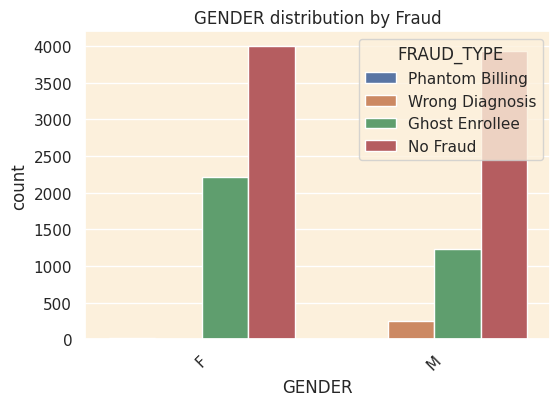

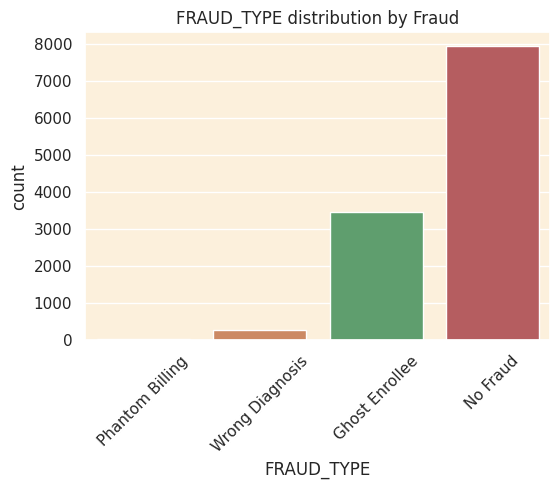

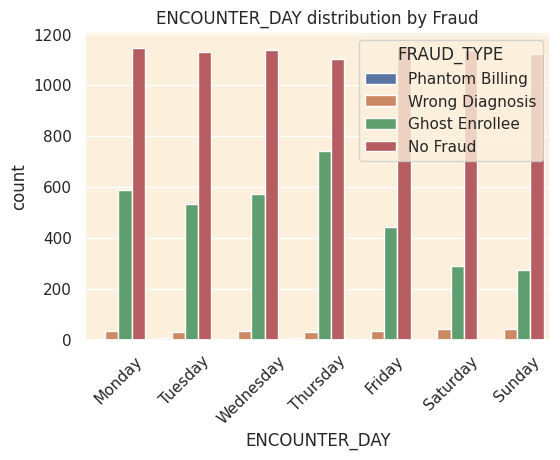

In [99]:
# Compare categorical feature distributions using countplots
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

for col in cat_features:
    plt.figure(figsize=(6,4))
    if col == 'ENCOUNTER_DAY':
      sns.countplot(x = col, hue = 'FRAUD_TYPE', data = df, order = day_order)
    else:
      sns.countplot(x = col, hue = 'FRAUD_TYPE', data = df)

    plt.title(f'{col} distribution by Fraud')
    plt.xticks(rotation=45)
    plt.show()

In [100]:
# Make the target to be binary (fraud vs non-fraud)
df['IS_FRAUD'] = df['FRAUD_TYPE'].apply(lambda x: 0 if x == "No Fraud" else 1)
df

,Patient ID,AGE,GENDER,DATE OF ENCOUNTER,DATE OF DISCHARGE,Amount Billed,DIAGNOSIS,FRAUD_TYPE,LENGTH_OF_STAY,ENCOUNTER_MONTH,ENCOUNTER_DAY,IS_FRAUD
0,1,25,F,2025-02-11,2025-02-11,16800.0,CYESIS LMP,Phantom Billing,0.0,2,Tuesday,1
1,2,30,M,2025-02-13,2025-02-13,6300.0,WAX IMPACTION,Wrong Diagnosis,0.0,2,Thursday,1
2,3,35,M,2025-02-13,2025-02-13,6160.0,CYESIS LMP,Wrong Diagnosis,0.0,2,Thursday,1
3,4,48,M,2025-02-18,2025-02-18,0.0,TONSILITIS OBSTRUCTIVE SLEEP APEANA,Ghost Enrollee,0.0,2,Tuesday,1
4,5,58,F,2025-02-18,2025-02-18,8400.0,REFRACTIVE ERROR,No Fraud,0.0,2,Tuesday,0
...,...,...,...,...,...,...,...,...,...,...,...,...
20377,19990,68,M,2020-07-28,2024-05-16,19755.0,POST TENSION BAND WIRING LEFT PATELLAR / HTN,No Fraud,365.0,7,Tuesday,0
20379,19992,14,M,2025-01-06,2025-12-18,14348.0,DYSPEPSIALUMBAR SPONDYLOSIS R/O DYSLIPIDEMI,No Fraud,346.0,1,Monday,0
20381,19994,14,M,2020-03-02,2024-04-18,14055.0,POORLY TREATED MALARIA,No Fraud,365.0,3,Monday,0
20382,19995,94,M,2022-01-15,2025-07-05,2474.0,RECTAL CA DM,No Fraud,365.0,1,Saturday,0


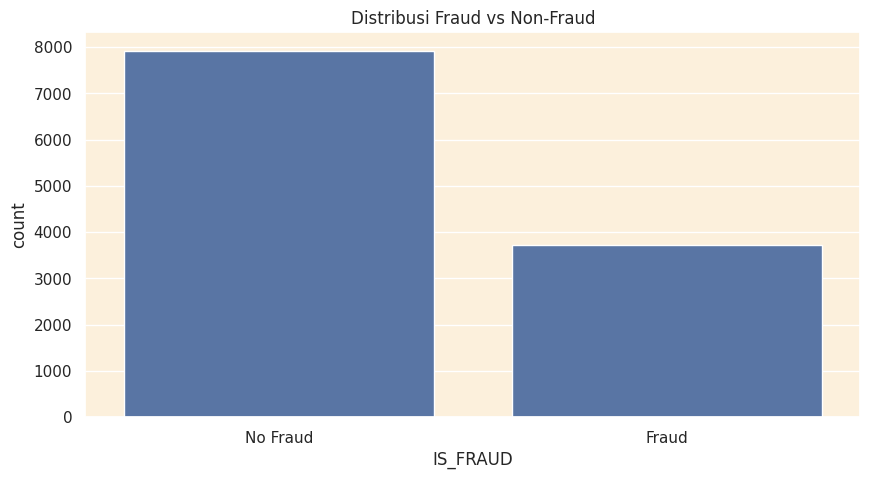

In [101]:
sns.countplot(x='IS_FRAUD', data=df)
plt.title("Distribusi Fraud vs Non-Fraud")
plt.xticks([0,1], ["No Fraud", "Fraud"])
plt.show()

# **5.&nbsp;Train-test split, Target Encoding and Feature Scaling**

In [102]:
# Define features (X) and target (y)
X = df.drop(['Patient ID','FRAUD_TYPE','IS_FRAUD','DATE OF ENCOUNTER','DATE OF DISCHARGE'], axis=1)
y = df['IS_FRAUD']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2,
                                                    random_state = 42,
                                                    stratify = y
)

In [103]:
# Target Encoding (fit in train data, transform to train & test)
cat_features = ['DIAGNOSIS', 'GENDER', 'ENCOUNTER_DAY']
te = TargetEncoder(cols=cat_features)

X_train_encoded = te.fit_transform(X_train, y_train)
X_test_encoded  = te.transform(X_test)

In [104]:
# Scale only numeric features
num_features = ['AGE', 'LENGTH_OF_STAY', 'Amount Billed']

# Fit scaler on TRAIN ONLY to avoid leakage ---
scaler = StandardScaler()
scaler.fit(X_train_encoded[num_features])

# Create scaled copies (keep originals untouched) ---
X_train_scaled = X_train_encoded.copy()
X_test_scaled  = X_test_encoded.copy()

X_train_scaled[num_features] = scaler.transform(X_train_encoded[num_features])
X_test_scaled[num_features]  = scaler.transform(X_test_encoded[num_features])

print("Shapes:", X_train.shape, X_test.shape)
print("Scaled preview:\n", X_train_scaled[num_features].head())

Shapes: (9320, 7) (2330, 7)
Scaled preview:
             AGE  LENGTH_OF_STAY  Amount Billed
16097  0.264201       -0.537463       0.506970
5863  -0.395511        0.915723      -0.563039
5391   1.143818        0.915723       0.411215
16703  0.572067        0.915723      -0.506279
2872  -0.087646       -1.285161      -1.096914


# **6.&nbsp;SMOTE**

In [105]:
# Handle imbalance (SMOTE, only in TRAIN)
sm = SMOTE(random_state=42)

# Convert AGE column to float before applying SMOTE
X_train_scaled['AGE'] = X_train_scaled['AGE'].astype(float)

X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)

print("Distribution before SMOTE:", y_train.value_counts())
print("Distribution after SMOTE:", y_train_res.value_counts())

Distribution before SMOTE: IS_FRAUD
0    6342
1    2978
Name: count, dtype: int64
Distribution after SMOTE: IS_FRAUD
0    6342
1    6342
Name: count, dtype: int64


# **7.&nbsp;Model Development**

In [106]:
def eval_model(name, model, Xtr, ytr, Xte, yte):
    model.fit(Xtr, ytr)
    y_pred  = model.predict(Xte)
    y_proba = model.predict_proba(Xte)[:, 1]  # probability of the positive class (fraud)

    print(f"\n=== {name} ===")
    print(classification_report(yte, y_pred, digits=4))
    print("ROC-AUC:", roc_auc_score(yte, y_proba))

    ConfusionMatrixDisplay.from_predictions(yte, y_pred, cmap='Blues', values_format='d')
    plt.title(f"Confusion Matrix — {name}")
    plt.show()


=== Logistic Regression ===
              precision    recall  f1-score   support

           0     0.9585    0.9319    0.9450      1585
           1     0.8631    0.9141    0.8879       745

    accuracy                         0.9262      2330
   macro avg     0.9108    0.9230    0.9164      2330
weighted avg     0.9280    0.9262    0.9267      2330

ROC-AUC: 0.961896131941651


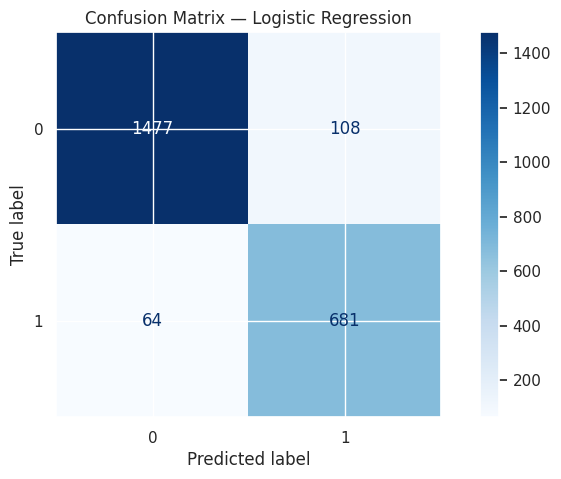

In [107]:
# ==========================
# 1) Logistic Regression
# ==========================
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(
    solver='saga',
    penalty='l2',
    C=1.0,
    max_iter=5000,
    random_state=42
    # class_weight not needed after SMOTE
)
eval_model("Logistic Regression", log_reg, X_train_res, y_train_res, X_test_scaled, y_test)


=== Random Forest ===
              precision    recall  f1-score   support

           0     0.9808    0.9685    0.9746      1585
           1     0.9346    0.9597    0.9470       745

    accuracy                         0.9657      2330
   macro avg     0.9577    0.9641    0.9608      2330
weighted avg     0.9661    0.9657    0.9658      2330

ROC-AUC: 0.9939868312408698


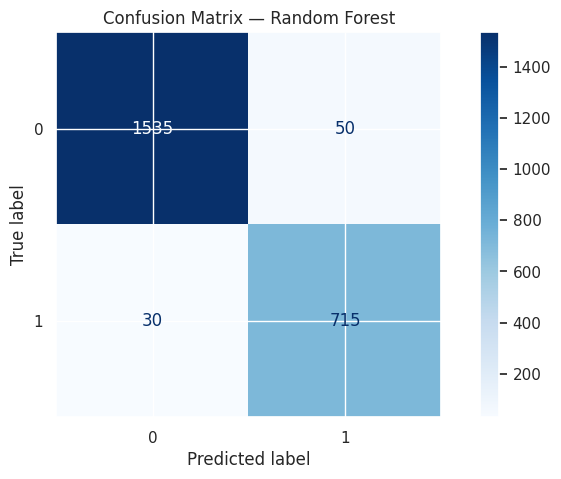

In [108]:
# ==========================
# 2) Random Forest
# ==========================
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
    # class_weight not needed after SMOTE
)
eval_model("Random Forest", rf, X_train_res, y_train_res, X_test_scaled, y_test)


=== XGBoost ===
              precision    recall  f1-score   support

           0     0.9708    0.9659    0.9684      1585
           1     0.9283    0.9383    0.9332       745

    accuracy                         0.9571      2330
   macro avg     0.9496    0.9521    0.9508      2330
weighted avg     0.9572    0.9571    0.9571      2330

ROC-AUC: 0.9898240636842884


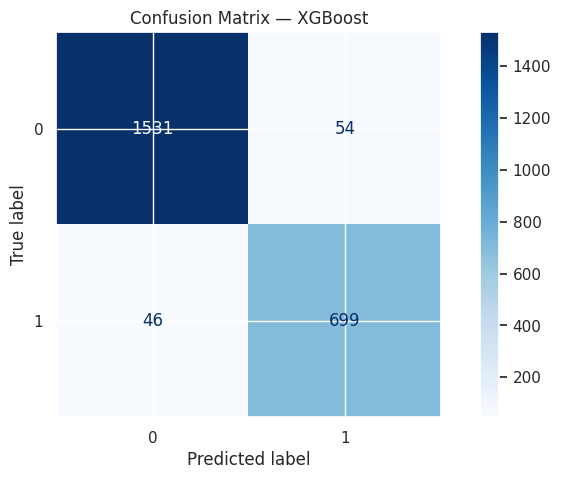

In [109]:
# ==========================
# 3) XGBoost (binary)
# ==========================
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=400,
    learning_rate=0.08,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    objective='binary:logistic',
    eval_metric='auc',
    random_state=42,
    n_jobs=-1,
    use_label_encoder=False
)
eval_model("XGBoost", xgb, X_train_res, y_train_res, X_test_scaled, y_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 6342, number of negative: 6342
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000268 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1328
[LightGBM] [Info] Number of data points in the train set: 12684, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

=== LightGBM ===
              precision    recall  f1-score   support

           0     0.9802    0.9697    0.9749      1585
           1     0.9370    0.9584    0.9476       745

    accuracy                         0.9661      2330
   macro avg     0.9586    0.9641    0.9613      2330
weighted avg     0.9664    0.9661    0.9662      2330

ROC-AUC: 0.9948967882624437


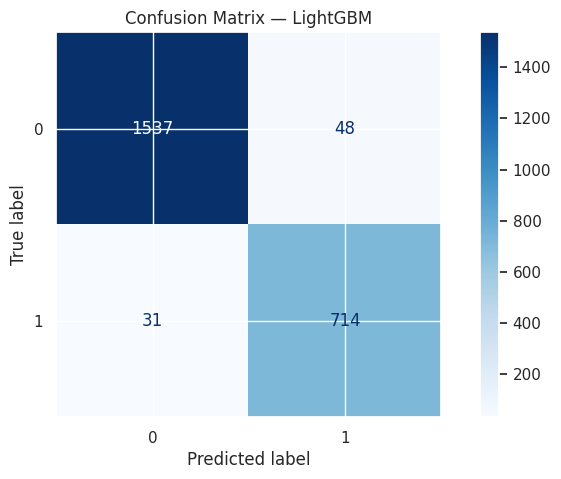

In [110]:
# ==========================
# 4) LightGBM (binary)
# ==========================
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(
    n_estimators=400,
    learning_rate=0.08,
    objective='binary',
    random_state=42
)
eval_model("LightGBM", lgbm, X_train_res, y_train_res, X_test_scaled, y_test)


=== CatBoost ===
              precision    recall  f1-score   support

           0     0.9815    0.9703    0.9759      1585
           1     0.9384    0.9611    0.9496       745

    accuracy                         0.9674      2330
   macro avg     0.9599    0.9657    0.9627      2330
weighted avg     0.9677    0.9674    0.9675      2330

ROC-AUC: 0.9954862066775347


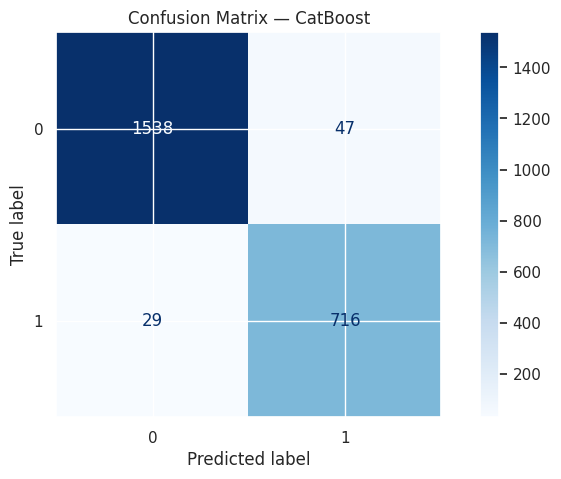

In [111]:
# ==========================
# 5) CatBoost (binary)
# ==========================
from catboost import CatBoostClassifier

cat = CatBoostClassifier(
    iterations=400,
    learning_rate=0.08,
    depth=6,
    loss_function='Logloss',   # binary
    eval_metric='AUC',
    random_seed=42,
    verbose=0
)
eval_model("CatBoost", cat, X_train_res, y_train_res, X_test_scaled, y_test)

# **8.&nbsp;Hyperparameter Tuning**

In [112]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
SCORING = 'roc_auc'  # use ROC-AUC for fraud detection

def run_grid(name, estimator, param_grid):
    print(f"\n===== {name}: GridSearchCV =====")
    grid = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        scoring=SCORING,
        cv=cv,
        n_jobs=-1,
        verbose=1
    )
    grid.fit(X_train_res, y_train_res)
    print("Best params:", grid.best_params_)
    print("Best CV ROC-AUC:", grid.best_score_)

    best = grid.best_estimator_

    # Evaluate on train (resampled) and test (real)
    y_proba_tr = best.predict_proba(X_train_res)[:, 1]
    y_pred_tr  = best.predict(X_train_res)
    y_proba_te = best.predict_proba(X_test_scaled)[:, 1]
    y_pred_te  = best.predict(X_test_scaled)

    print("\n--- Train performance (on resampled train) ---")
    print("ROC-AUC (train):", roc_auc_score(y_train_res, y_proba_tr))
    print(classification_report(y_train_res, y_pred_tr, digits=4))

    print("\n--- Test performance ---")
    print("ROC-AUC (test):", roc_auc_score(y_test, y_proba_te))
    print(classification_report(y_test, y_pred_te, digits=4))

    gap = roc_auc_score(y_train_res, y_proba_tr) - roc_auc_score(y_test, y_proba_te)
    print(f"Generalization gap (ROC-AUC train - test): {gap:.4f}")
    return best

# 1) Logistic Regression (binary)
lr_grid = {
    'C': [0.1, 0.5, 1.0, 2.0, 5.0],
    'penalty': ['l2'],
    'solver': ['saga'],        # supports l1/l2/elasticnet; we use l2 here
    'max_iter': [5000]
}
lr_best = run_grid(
    "Logistic Regression",
    LogisticRegression(random_state=42),
    lr_grid
)

# 2) Random Forest
rf_grid = {
    'n_estimators': [200, 300, 500],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2', None]
}
rf_best = run_grid(
    "Random Forest",
    RandomForestClassifier(random_state=42, n_jobs=-1),
    rf_grid
)

# 3) XGBoost (binary)
xgb_grid = {
    'n_estimators': [300, 400, 600],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.05, 0.08, 0.1],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'reg_lambda': [1.0, 3.0, 5.0]
}
xgb_best = run_grid(
    "XGBoost",
    XGBClassifier(
        objective='binary:logistic',
        eval_metric='auc',
        random_state=42,
        n_jobs=-1,
        use_label_encoder=False
    ),
    xgb_grid
)

# 4) LightGBM (binary)
lgbm_grid = {
    'n_estimators': [300, 400, 600],
    'num_leaves': [31, 63, 127],
    'max_depth': [-1, 8, 12],
    'learning_rate': [0.05, 0.08, 0.1],
    'subsample': [0.8, 0.9, 1.0],          # bagging_fraction alias
    'colsample_bytree': [0.8, 0.9, 1.0]    # feature_fraction alias
}
lgbm_best = run_grid(
    "LightGBM",
    LGBMClassifier(objective='binary', random_state=42),
    lgbm_grid
)

# 5) CatBoost (binary)
# Note: CatBoost ignores n_jobs; use thread_count instead.
cat_grid = {
    'iterations': [300, 500, 700],
    'depth': [4, 6, 8],
    'learning_rate': [0.05, 0.08, 0.1],
    'l2_leaf_reg': [1.0, 3.0, 5.0]
}
cat_best = run_grid(
    "CatBoost",
    CatBoostClassifier(
        loss_function='Logloss',
        eval_metric='AUC',
        random_seed=42,
        verbose=0,
        thread_count=-1
    ),
    cat_grid
)



===== Logistic Regression: GridSearchCV =====
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best params: {'C': 5.0, 'max_iter': 5000, 'penalty': 'l2', 'solver': 'saga'}
Best CV ROC-AUC: 0.9735717425516569

--- Train performance (on resampled train) ---
ROC-AUC (train): 0.9738833460083154
              precision    recall  f1-score   support

           0     0.9416    0.9432    0.9424      6342
           1     0.9431    0.9415    0.9423      6342

    accuracy                         0.9424     12684
   macro avg     0.9424    0.9424    0.9424     12684
weighted avg     0.9424    0.9424    0.9424     12684


--- Test performance ---
ROC-AUC (test): 0.9624067918616221
              precision    recall  f1-score   support

           0     0.9578    0.9306    0.9440      1585
           1     0.8608    0.9128    0.8860       745

    accuracy                         0.9249      2330
   macro avg     0.9093    0.9217    0.9150      2330
weighted avg     0.9268    0.9249   

### 8.1 Summary

In [113]:
def summarize_models(models, X_train, y_train, X_test, y_test, sort_by="Test ROC-AUC"):
    """
    models: dict -> {"Model Name": fitted_estimator, ...}
    X_train, y_train: training set used to fit (here: SMOTE’d & scaled)
    X_test, y_test  : holdout test set (scaled, no SMOTE)
    """
    rows = []
    for name, model in models.items():
        # Probabilities (positive class = 1)
        p_tr = model.predict_proba(X_train)[:, 1]
        p_te = model.predict_proba(X_test)[:, 1]
        # Labels (threshold = 0.5 by default)
        yhat_tr = (p_tr >= 0.5).astype(int)
        yhat_te = (p_te >= 0.5).astype(int)

        # Train metrics
        auc_tr = roc_auc_score(y_train, p_tr)
        ap_tr  = average_precision_score(y_train, p_tr)
        prec_tr, rec_tr, f1_tr, _ = precision_recall_fscore_support(
            y_train, yhat_tr, average="binary", zero_division=0
        )
        acc_tr = accuracy_score(y_train, yhat_tr)

        # Test metrics
        auc_te = roc_auc_score(y_test, p_te)
        ap_te  = average_precision_score(y_test, p_te)
        prec_te, rec_te, f1_te, _ = precision_recall_fscore_support(
            y_test, yhat_te, average="binary", zero_division=0
        )
        acc_te = accuracy_score(y_test, yhat_te)

        # Generalization gap (AUC train - test)
        gap = auc_tr - auc_te

        rows.append({
            "Model": name,
            "Train ROC-AUC": auc_tr,
            "Test ROC-AUC": auc_te,
            "Gen Gap (AUC)": gap,
            "Train PR-AUC": ap_tr,
            "Test PR-AUC": ap_te,
            "Train Precision": prec_tr,
            "Train Recall": rec_tr,
            "Train F1": f1_tr,
            "Train Acc": acc_tr,
            "Test Precision": prec_te,
            "Test Recall": rec_te,
            "Test F1": f1_te,
            "Test Acc": acc_te,
            # quick overfitting flag (tweak threshold if you like)
            "Overfit?": "Yes" if gap >= 0.10 else "No"
        })

    df = pd.DataFrame(rows)
    # Order columns nicely
    cols = [
        "Model",
        "Train ROC-AUC", "Test ROC-AUC", "Gen Gap (AUC)",
        "Train PR-AUC", "Test PR-AUC",
        "Train Precision", "Train Recall", "Train F1", "Train Acc",
        "Test Precision", "Test Recall", "Test F1", "Test Acc",
        "Overfit?"
    ]
    df = df[cols].sort_values(by=sort_by, ascending=False).reset_index(drop=True)
    # Round numeric columns for readability
    for c in df.columns:
        if df[c].dtype.kind in "fc":
            df[c] = df[c].round(4)
    return df

# ===== Usage =====
# Assuming you’ve already fit your tuned models on X_train_res, y_train_res:
# log_reg, rf, xgb, lgbm, cat

models = {
    "Logistic Regression": lr_best,
    "Random Forest": rf_best,
    "XGBoost": xgb_best,
    "LightGBM": lgbm_best,
    "CatBoost": cat_best
}

summary_df = summarize_models(
    models,
    X_train=X_train_res, y_train=y_train_res,   # SMOTE’d & scaled
    X_test=X_test_scaled, y_test=y_test         # scaled only
)
summary_df
# Optionally save:
# summary_df.to_csv("model_comparison_summary.csv", index=False)

,Model,Train ROC-AUC,Test ROC-AUC,Gen Gap (AUC),Train PR-AUC,Test PR-AUC,Train Precision,Train Recall,Train F1,Train Acc,Test Precision,Test Recall,Test F1,Test Acc,Overfit?
0,LightGBM,1.0000,0.9955,0.0045,1.0000,0.9924,1.0000,1.0000,1.0000,1.0000,0.9421,0.9611,0.9515,0.9687,No
1,CatBoost,1.0000,0.9952,0.0047,1.0000,0.9920,0.9991,0.9973,0.9982,0.9982,0.9323,0.9611,0.9465,0.9652,No
2,Random Forest,0.9999,0.9946,0.0053,0.9999,0.9914,0.9954,0.9946,0.9950,0.9950,0.9299,0.9611,0.9452,0.9644,No
3,XGBoost,0.9998,0.9910,0.0088,0.9998,0.9759,0.9954,0.9957,0.9956,0.9956,0.9275,0.9450,0.9362,0.9588,No
4,Logistic Regression,0.9739,0.9624,0.0115,0.9753,0.9416,0.9431,0.9415,0.9423,0.9424,0.8608,0.9128,0.8860,0.9249,No


In [114]:
# ---- save_artifacts.py (jalankan di notebook) ----
import joblib
import json

# pilih satu model terbaik (atau simpan semua bila mau)
best_models = {
    "logreg": lr_best,
    "rf": rf_best,
    "xgb": xgb_best,
    "lgbm": lgbm_best,
    "cat": cat_best
}

# simpan model pilihan utama (misal XGBoost)
joblib.dump(best_models["xgb"], "model_xgb.pkl")

# simpan juga model lain kalau ingin selectable di UI
joblib.dump(best_models["logreg"], "model_logreg.pkl")
joblib.dump(best_models["rf"], "model_rf.pkl")
joblib.dump(best_models["lgbm"], "model_lgbm.pkl")
joblib.dump(best_models["cat"], "model_cat.pkl")

# simpan encoder & scaler yang dipakai waktu training
joblib.dump(te, "target_encoder.pkl")
joblib.dump(scaler, "scaler.pkl")

# simpan metadata fitur agar preprocessing di Streamlit konsisten
meta = {
    "drop_cols": ["FRAUD_TYPE", "IS_FRAUD", "DATE OF ENCOUNTER", "DATE OF DISCHARGE"],
    "cat_features": ["DIAGNOSIS", "GENDER", "ENCOUNTER_DAY"],
    "num_features": ["AGE", "LENGTH_OF_STAY", "Amount Billed"],
    "id_cols": ["Patient ID"]  # tidak dipakai ke model, hanya untuk display
}
with open("meta.json", "w") as f:
    json.dump(meta, f, indent=2)


In [115]:
summary_df.to_csv("model_comparison_summary.csv", index=False)